# Fig. 3 and Fig. S8: Plotting MI vs. Lenslets for different Datasets, Multiplexing Levels, and IDEAL designs

In [1]:
import os
import sys
# set gpu to be pci bus id
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# set gpu memory usage and turnoff pre-allocated memory
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import optax
import equinox as eqx
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
test = jnp.zeros((10,10,10))
import jax.random as random

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
from cleanplots import * 
import scipy

# %%
import sys
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/EncodingInformation/src/')
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/EncodingInformation/ideal/')
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/EncodingInformation/lensless_imager/')
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/optimization_scripts/')
from lensless_helpers import * 

# %%
from encoding_information import extract_patches
from encoding_information.models import PixelCNN
from encoding_information.plot_utils import plot_samples
from encoding_information.models import PoissonNoiseModel
from encoding_information.image_utils import add_noise
from encoding_information import estimate_information

from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist
import tensorflow as tf


# %%
# import specific imaging system's modules 
from imaging_system import ImagingSystem, ImagingSystemProtocol
from lensless_imaging_system import RMLPSFLayer
from lensless_data_generator import LenslessDataGenerator
from lensless_imaging_system_diagonal_covs import RMLPSFLayer as RMLPSFLayerDiagCovs
from lensless_imaging_system_diagonal_covs import LenslessImagingSystem

2025-12-23 18:24:43.119733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766543083.136906 3837215 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766543083.142284 3837215 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from cleanplots import * 

In [3]:
# set seed values for reproducibility
seed_values_full = [4, 42, 31, 50, 77] # 5 arbitrary seed values 

# set photon properties 
bias = 10 # in photons
mean_photon_count_list = [100]

# set eligible psfs

psf_names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
psf_names_nice = ['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

# MI estimator parameters 
patch_size = 32
num_patches = 10000
val_set_size = 1000
test_set_size = 1500 
num_samples = 8
learning_rate = 1e-3
num_iters_per_epoch = 500
patience_val = 20

In [4]:
# RMLPSFLayer parameters 
object_size = 96 
num_gaussian = 25
psf_size = (32, 32) 
# general parameters 
seed_value = 42
key = jax.random.PRNGKey(seed_value)

In [5]:
mnist_folder = '/home/lakabuli/workspace/LenslessInfoDesign/tradeoff_analysis/mi_estimates/mnist_mi_estimates/'
cifar_folder = '/home/lakabuli/workspace/LenslessInfoDesign/tradeoff_analysis/mi_estimates/cifar10_mi_estimates/'
fashion_folder = '/home/lakabuli/workspace/LenslessInfoDesign/tradeoff_analysis/mi_estimates/fashion_mnist_mi_estimates/'
bead_folder = '/home/lakabuli/workspace/LenslessInfoDesign/tradeoff_analysis/mi_estimates/bead_mi_estimates/'
figure_folder = '/home/lakabuli/workspace/LenslessInfoDesign/figures/'

dataset_names = ['cifar10', 'fashion_mnist', 'mnist', 'bead']
dataset_names_nice = ['CIFAR10', 'Fashion-MNIST', 'MNIST', 'Bead']
folder_names = [cifar_folder, fashion_folder, mnist_folder]


In [6]:
sparsity_level = 0.02 # use 0.02 beads

## Load the MI estimates for heuristic designs

In [7]:
mi_estimates_across_datasets = []
mi_lower_bounds_across_datasets = []
mi_upper_bounds_across_datasets = []
mi_min_val_across_datasets = []
for dataset_idx, save_dir in enumerate(folder_names):
    for mean_photon_count in mean_photon_count_list: 
        mi_estimates_across_psfs = []
        mi_lower_bounds_across_psfs = []
        mi_upper_bounds_across_psfs = []
        for psf_index, psf_name in enumerate(psf_names):
            mi_array = np.load(save_dir + '{}_pixelcnn_mi_estimate_{}_photons_{}_psf_{}_lr_{}_patience_{}_steps_per_epoch.npy'.format(
                dataset_names[dataset_idx], mean_photon_count, psf_name, learning_rate, patience_val, num_iters_per_epoch), allow_pickle=True)
            # MI arrays are of shape (3, num_seeds) and contain mi_estimates, lower_bounds, then upper bounds
            # isolate the minimum MI value and the corresponding bounds 
            best_mi_value, best_mi_idx = np.min(mi_array[0]), np.argmin(mi_array[0])
            best_mi_lower_bound = mi_array[1][best_mi_idx]
            best_mi_upper_bound = mi_array[2][best_mi_idx]
            mi_estimates_across_psfs.append(best_mi_value)
            mi_lower_bounds_across_psfs.append(best_mi_lower_bound)
            mi_upper_bounds_across_psfs.append(best_mi_upper_bound)
            print('MI estimates for {} PSF: {}, {}'.format(psf_name, best_mi_value, mi_array[0]), best_mi_idx)
        mi_estimates_across_psfs = np.array(mi_estimates_across_psfs)
        mi_lower_bounds_across_psfs = np.array(mi_lower_bounds_across_psfs)
        mi_upper_bounds_across_psfs = np.array(mi_upper_bounds_across_psfs)
        # add these to the bigger loop 
        mi_estimates_across_datasets.append(mi_estimates_across_psfs)
        mi_lower_bounds_across_datasets.append(mi_lower_bounds_across_psfs)
        mi_upper_bounds_across_datasets.append(mi_upper_bounds_across_psfs)

# add bead data in as well
dataset_idx = 3
save_dir = bead_folder
for mean_photon_count in mean_photon_count_list: 
    mi_estimates_across_psfs = []
    mi_lower_bounds_across_psfs = []
    mi_upper_bounds_across_psfs = []
    print("sparsity level is {}".format(sparsity_level))
    for psf_index, psf_name in enumerate(psf_names):
        mi_array = np.load(save_dir + 'pixelcnn_mi_estimate_{}_sparsity_{}_photons_{}_psf_{}_lr_{}_patience_{}_steps_per_epoch.npy'.format(
            sparsity_level, mean_photon_count, psf_name, learning_rate, patience_val, num_iters_per_epoch), allow_pickle=True)
        # isolate the minimum MI value and the corresponding bounds 
        best_mi_value, best_mi_idx = np.min(mi_array[0]), np.argmin(mi_array[0])
        best_mi_lower_bound = mi_array[1][best_mi_idx]
        best_mi_upper_bound = mi_array[2][best_mi_idx]
        mi_estimates_across_psfs.append(best_mi_value)
        mi_lower_bounds_across_psfs.append(best_mi_lower_bound)
        mi_upper_bounds_across_psfs.append(best_mi_upper_bound)
        print('MI estimates for {} PSF: {}, {}'.format(psf_name, best_mi_value, mi_array[0]), best_mi_idx)
    mi_estimates_across_psfs = np.array(mi_estimates_across_psfs)
    mi_lower_bounds_across_psfs = np.array(mi_lower_bounds_across_psfs)
    mi_upper_bounds_across_psfs = np.array(mi_upper_bounds_across_psfs)
    # add these to the bigger loop 
    mi_estimates_across_datasets.append(mi_estimates_across_psfs)
    mi_lower_bounds_across_datasets.append(mi_lower_bounds_across_psfs)
    mi_upper_bounds_across_datasets.append(mi_upper_bounds_across_psfs)
mi_estimates_across_datasets = np.array(mi_estimates_across_datasets)
mi_lower_bounds_across_datasets = np.array(mi_lower_bounds_across_datasets)
mi_upper_bounds_across_datasets = np.array(mi_upper_bounds_across_datasets) 

MI estimates for one PSF: 0.3952649652638099, [0.39526497 0.40099961 0.40760707 0.4032341  0.40314005] 0
MI estimates for two PSF: 0.32491987460911687, [0.32491987 0.32547633 0.33190942 0.32591144 0.32868889] 0
MI estimates for three PSF: 0.2801500160177743, [0.28015002 0.28208542 0.28743605 0.28259028 0.28576606] 0
MI estimates for four PSF: 0.2517461828765215, [0.25174618 0.25544604 0.26179427 0.25591536 0.25818784] 0
MI estimates for five PSF: 0.22819925975078775, [0.22819926 0.23211328 0.23795174 0.23384589 0.23579619] 0
MI estimates for six PSF: 0.2068947183972186, [0.20689472 0.21240582 0.21809594 0.21325991 0.21405666] 0
MI estimates for seven PSF: 0.1913647571691955, [0.19136476 0.19475959 0.20119837 0.19624386 0.19756275] 0
MI estimates for eight PSF: 0.18214939717549797, [0.1821494  0.18638966 0.19108063 0.18574183 0.18692787] 0
MI estimates for nine PSF: 0.16907901690504887, [0.16907902 0.17265217 0.17705445 0.17238738 0.17399718] 0
MI estimates for one PSF: 0.29779560470059

Load the MI for the random init for each design

In [8]:
bead_random_init_psf_path = '/home/lakabuli/workspace/LenslessInfoDesign/tradeoff_analysis/mi_estimates/bead_mi_estimates/bead_0.02_sparsity_pixelcnn_mi_estimate_100_photons_random_init_ideal_psf_0.001_lr_20_patience_500_steps_per_epoch.npy'
bead_random_init_psf_mi_values = np.load(bead_random_init_psf_path, allow_pickle=True)
bead_random_init_psf_mi = np.min(bead_random_init_psf_mi_values[0])

In [9]:
mnist_random_init_psf_path = '/home/lakabuli/workspace/LenslessInfoDesign/tradeoff_analysis/mi_estimates/mnist_mi_estimates/mnist_pixelcnn_mi_estimate_100_photons_random_init_ideal_psf_0.001_lr_20_patience_500_steps_per_epoch.npy'
mnist_random_init_psf_mi_values = np.load(mnist_random_init_psf_path, allow_pickle=True)
mnist_random_init_psf_mi = np.min(mnist_random_init_psf_mi_values[0])

In [10]:
fashion_random_init_psf_path = '/home/lakabuli/workspace/LenslessInfoDesign/tradeoff_analysis/mi_estimates/fashion_mnist_mi_estimates/fashion_mnist_pixelcnn_mi_estimate_100_photons_random_init_ideal_psf_0.001_lr_20_patience_500_steps_per_epoch.npy'
fashion_random_init_psf_mi_values = np.load(fashion_random_init_psf_path, allow_pickle=True)
fashion_random_init_psf_mi = np.min(fashion_random_init_psf_mi_values[0])
print(fashion_random_init_psf_mi_values, fashion_random_init_psf_mi)


[[0.15989031 0.14452928 0.14808193 0.15669856 0.14941028]
 [0.15006934 0.13157644 0.13594923 0.14714843 0.13577307]
 [0.17124484 0.15537972 0.15859752 0.1673441  0.16036833]] 0.14452928191946782


In [11]:
cifar_random_init_psf_path = '/home/lakabuli/workspace/LenslessInfoDesign/tradeoff_analysis/mi_estimates/cifar10_mi_estimates/cifar10_pixelcnn_mi_estimate_100_photons_random_init_ideal_psf_0.001_lr_20_patience_500_steps_per_epoch.npy'
cifar_random_init_psf_mi_values = np.load(cifar_random_init_psf_path, allow_pickle=True)
cifar_random_init_psf_mi = np.min(cifar_random_init_psf_mi_values[0])
print(cifar_random_init_psf_mi_values, cifar_random_init_psf_mi)


[[0.06807594 0.07029272 0.07576788 0.07130472 0.07300787]
 [0.06154206 0.06446776 0.07011012 0.06459449 0.06717368]
 [0.07354085 0.07612664 0.08004109 0.07659848 0.07890561]] 0.0680759381575821


## Load the PSFs and MI estimates for each of the IDEAL designs, Random init and heuristic init

In [12]:
ideal_model_dir = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/'

In [13]:
ideal_psfs_save_as_npy_dir = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/IDEAL_psfs/'

Lenslet design for seed 42 random initialization with 25 lenslets

In [14]:
random_init_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/random_psf_init_seed_42.npy'
random_init_psf = np.load(random_init_path, allow_pickle=True)

### Beads

#### Beads with random initialization

0.66297525
0.8378397
[0.         0.         0.18061104 0.06733426 0.14397416 0.00070243
 0.         0.07925723 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.25104582 0.27707502 0.         0.         0.         0.
 0.        ]


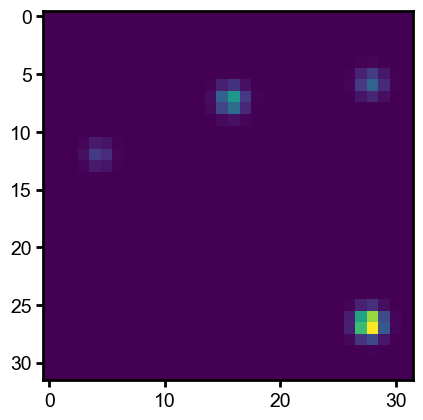

In [15]:
bead_random_init_mi_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/mi_estimates/bead_0.02_sparsity_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_1e-4_weight_lr_clean_images_seed_42.npy'
mi_values = np.load(bead_random_init_mi_path, allow_pickle=True)
best_bead_mi, best_bead_lower, best_bead_upper = mi_values
print(best_bead_mi)
best_bead_mi_lenslet_count = 4

bead_random_init_tc_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/tc_values/bead_0.02_sparsity_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_1e-4_weight_lr_clean_images_seed_42.npy'
tc_values = np.load(bead_random_init_tc_path, allow_pickle=True).item()
best_bead_tc = tc_values['patch_noisy'][0]
print(best_bead_tc)

bead_random_init_model_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/bead_0.02_sparsity_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_1e-4_weight_lr_clean_images_seed_42_optimized_imaging_system.eqx'

psf_layer = RMLPSFLayerDiagCovs(object_size, num_gaussian, psf_size=psf_size, key=key)
imaging_system = LenslessImagingSystem(psf_layer)
loaded_imaging_system = eqx.tree_deserialise_leaves(bead_random_init_model_path, imaging_system)

print(loaded_imaging_system.psf_layer.weights)
bead_psf_image = loaded_imaging_system.psf_layer.compute_psf()
plt.imshow(bead_psf_image)

In [16]:
np.save(ideal_psfs_save_as_npy_dir + 'ideal_bead_0.02_psf.npy', bead_psf_image)

Beads with heuristic initialization

0.6678685
0.75834507
[0.2 0.2 0.2 0.2 0.2]


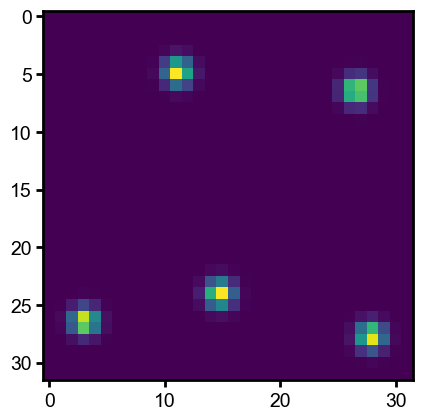

In [17]:
bead_heuristic_init_mi_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/mi_estimates/bead_0.02_sparsity_diagonal_cov_sigma_08_heuristic_init_5_lenslets_4096_patches_3e-2_mean_0_weight_lr_clean_images_seed_42.npy'
mi_values = np.load(bead_heuristic_init_mi_path, allow_pickle=True)
best_bead_heuristic_mi, best_bead_heuristic_lower, best_bead_heuristic_upper = mi_values
print(best_bead_heuristic_mi)
best_bead_heuristic_lenslet_count = 5

bead_heuristic_init_tc_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/tc_values/bead_0.02_sparsity_diagonal_cov_sigma_08_heuristic_init_5_lenslets_4096_patches_3e-2_mean_0_weight_lr_clean_images_seed_42.npy'
tc_values = np.load(bead_heuristic_init_tc_path, allow_pickle=True).item()
best_bead_heuristic_tc = tc_values['patch_noisy'][0]
print(best_bead_heuristic_tc)

bead_heuristic_init_model_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/bead_0.02_sparsity_diagonal_cov_sigma_08_heuristic_init_5_lenslets_4096_patches_3e-2_mean_0_weight_lr_clean_images_seed_42_optimized_imaging_system.eqx'

psf_layer = RMLPSFLayerDiagCovs(object_size, 5, psf_size, key=key)

imaging_system = LenslessImagingSystem(psf_layer)
loaded_imaging_system = eqx.tree_deserialise_leaves(bead_heuristic_init_model_path, imaging_system)
print(loaded_imaging_system.psf_layer.weights)
bead_heuristic_psf_image = loaded_imaging_system.psf_layer.compute_psf()
plt.imshow(bead_heuristic_psf_image)

In [18]:
np.save(ideal_psfs_save_as_npy_dir + 'ideal_heuristic_bead_0.02_psf.npy', bead_heuristic_psf_image)

### CIFAR10

CIFAR10 with random initialization 

0.40620548
0.8527488
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


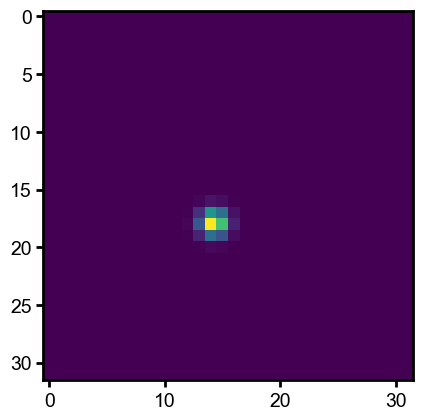

In [19]:
cifar_random_init_mi_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/mi_estimates/cifar10_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_3e-4_weight_lr_clean_images_seed_42.npy'
mi_values = np.load(cifar_random_init_mi_path, allow_pickle=True)
best_cifar_mi, best_cifar_lower, best_cifar_upper = mi_values
print(best_cifar_mi)
best_cifar_mi_lenslet_count = 1

cifar_random_init_tc_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/tc_values/cifar10_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_3e-4_weight_lr_clean_images_seed_42.npy'
tc_values = np.load(cifar_random_init_tc_path, allow_pickle=True).item()
best_cifar_tc = tc_values['patch_noisy'][0]
print(best_cifar_tc)

cifar_random_init_model_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/cifar10_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_3e-4_weight_lr_clean_images_seed_42_optimized_imaging_system.eqx'
# define the PSF layer

psf_layer = RMLPSFLayerDiagCovs(object_size, num_gaussian, psf_size, key=key)

imaging_system = LenslessImagingSystem(psf_layer)

loaded_imaging_system = eqx.tree_deserialise_leaves(cifar_random_init_model_path, imaging_system)

print(loaded_imaging_system.psf_layer.weights)
cifar_psf_image = loaded_imaging_system.psf_layer.compute_psf()
plt.imshow(cifar_psf_image)

In [20]:
np.save(ideal_psfs_save_as_npy_dir + 'ideal_cifar_psf.npy', cifar_psf_image)

CIFAR10 with Heuristic initialization

0.4096974
0.85230196
[1.]


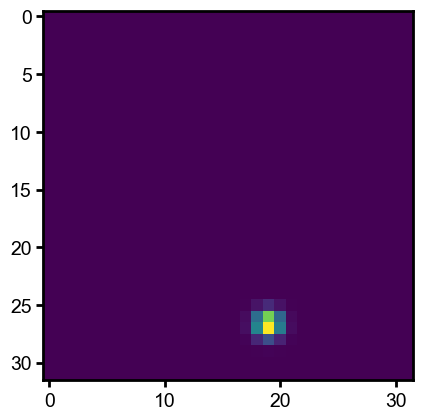

In [21]:
cifar_heuristic_init_mi_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/mi_estimates/cifar10_diagonal_cov_sigma_08_heuristic_init_means_and_covs_1_lenslets_4096_patches_3e-2_mean_0_weights_lr_clean_images_seed_42.npy'
mi_values = np.load(cifar_heuristic_init_mi_path, allow_pickle=True)
best_cifar_heuristic_mi, best_cifar_heuristic_lower, best_cifar_heuristic_upper = mi_values
print(best_cifar_heuristic_mi)
best_cifar_heuristic_mi_lenslet_count = 1

cifar_heuristic_init_tc_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/tc_values/cifar10_diagonal_cov_sigma_08_heuristic_init_means_and_covs_1_lenslets_4096_patches_3e-2_mean_0_weights_lr_clean_images_seed_42.npy'
tc_values = np.load(cifar_heuristic_init_tc_path, allow_pickle=True).item()
best_cifar_heuristic_tc = tc_values['patch_noisy'][0]
print(best_cifar_heuristic_tc)

cifar_heuristic_init_model_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/cifar10_diagonal_cov_sigma_08_heuristic_init_means_and_covs_1_lenslets_4096_patches_3e-2_mean_0_weights_lr_clean_images_seed_42_optimized_imaging_system.eqx'

psf_layer = RMLPSFLayerDiagCovs(object_size, 1, psf_size, key=key)

imaging_system = LenslessImagingSystem(psf_layer)

loaded_imaging_system = eqx.tree_deserialise_leaves(cifar_heuristic_init_model_path, imaging_system)

print(loaded_imaging_system.psf_layer.weights)
cifar_heuristic_psf_image = loaded_imaging_system.psf_layer.compute_psf()
plt.imshow(cifar_heuristic_psf_image)


In [22]:
np.save(ideal_psfs_save_as_npy_dir + 'ideal_heuristic_cifar_psf.npy', cifar_heuristic_psf_image)

### Fashion MNIST

Fashion MNIST with random initialization

0.51047957
0.880128
[0.         0.         0.22543883 0.05133833 0.09289189 0.
 0.         0.19165535 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.1725374  0.2661382  0.         0.         0.         0.
 0.        ]


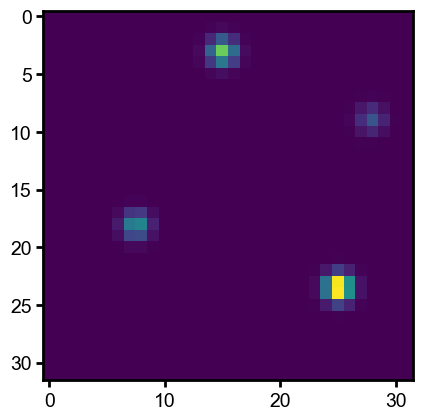

In [23]:
fashion_mnist_random_init_mi_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/mi_estimates/fashion_mnist_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_1e-4_weight_lr_clean_images_seed_42.npy'
mi_values = np.load(fashion_mnist_random_init_mi_path, allow_pickle=True)
best_fashion_mi, best_fashion_lower, best_fashion_upper = mi_values
print(best_fashion_mi)
best_fashion_mi_lenslet_count = 4

fashion_mnist_random_init_tc_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/tc_values/fashion_mnist_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_1e-4_weight_lr_clean_images_seed_42.npy'
tc_values = np.load(fashion_mnist_random_init_tc_path, allow_pickle=True).item()
best_fashion_tc = tc_values['patch_noisy'][0]
print(best_fashion_tc)

fashion_mnist_random_init_model_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/fashion_mnist_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_3e-2_mean_1e-4_weight_lr_clean_images_seed_42_optimized_imaging_system.eqx'

psf_layer = RMLPSFLayerDiagCovs(object_size, num_gaussian, psf_size, key=key)

imaging_system = LenslessImagingSystem(psf_layer)

loaded_imaging_system = eqx.tree_deserialise_leaves(fashion_mnist_random_init_model_path, imaging_system)

print(loaded_imaging_system.psf_layer.weights)
fashion_psf_image = loaded_imaging_system.psf_layer.compute_psf()
plt.imshow(fashion_psf_image)

In [24]:
np.save(ideal_psfs_save_as_npy_dir + 'ideal_fashion_psf.npy', fashion_psf_image)

Fashion MNIST with heuristic initialization

0.5106918
0.8060982
[0.25 0.25 0.25 0.25]


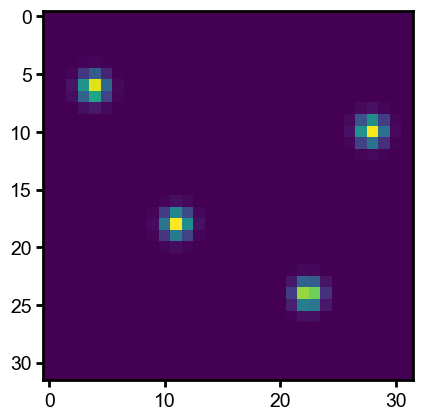

In [25]:
fashion_mnist_heuristic_init_mi_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/mi_estimates/fashion_mnist_diagonal_cov_sigma_08_heuristic_init_means_and_covs_4_lenslets_4096_patches_3e-2_mean_0_weights_lr_clean_images_seed_42.npy'
mi_values = np.load(fashion_mnist_heuristic_init_mi_path, allow_pickle=True)
best_fashion_heuristic_mi, best_fashion_heuristic_lower, best_fashion_heuristic_upper = mi_values
print(best_fashion_heuristic_mi)
best_fashion_heuristic_mi_lenslet_count = 4

fashion_mnist_heuristic_init_tc_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/tc_values/fashion_mnist_diagonal_cov_sigma_08_heuristic_init_means_and_covs_4_lenslets_4096_patches_3e-2_mean_0_weights_lr_clean_images_seed_42.npy'
tc_values = np.load(fashion_mnist_heuristic_init_tc_path, allow_pickle=True).item()
best_fashion_heuristic_tc = tc_values['patch_noisy'][0]
print(best_fashion_heuristic_tc)

fashion_mnist_heuristic_init_model_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/fashion_mnist_diagonal_cov_sigma_08_heuristic_init_means_and_covs_4_lenslets_4096_patches_3e-2_mean_0_weights_lr_clean_images_seed_42_optimized_imaging_system.eqx'

psf_layer = RMLPSFLayerDiagCovs(object_size, 4, psf_size, key=key)

imaging_system = LenslessImagingSystem(psf_layer)

loaded_imaging_system = eqx.tree_deserialise_leaves(fashion_mnist_heuristic_init_model_path, imaging_system)

print(loaded_imaging_system.psf_layer.weights)
fashion_heuristic_psf_image = loaded_imaging_system.psf_layer.compute_psf()
plt.imshow(fashion_heuristic_psf_image)

In [26]:
np.save(ideal_psfs_save_as_npy_dir + 'ideal_heuristic_fashion_psf.npy', fashion_heuristic_psf_image)

### MNIST

MNIST with random initialization

0.8786029
[0.         0.         0.03153025 0.         0.22321855 0.20908462
 0.         0.11635914 0.         0.         0.092655   0.
 0.         0.         0.         0.         0.08342464 0.
 0.03541676 0.14004129 0.         0.         0.06826985 0.
 0.        ]


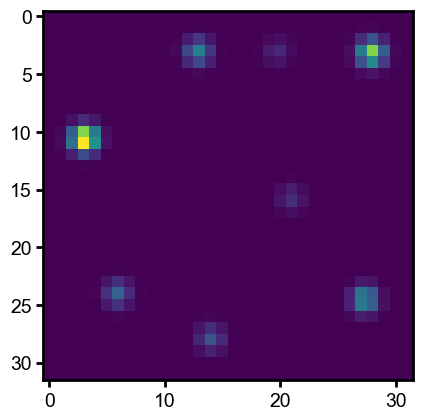

In [27]:
mnist_random_init_mi_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/mi_estimates/mnist_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_5e-3_mean_lr_clean_images_seed_42.npy'
mi_values = np.load(mnist_random_init_mi_path, allow_pickle=True)
best_mnist_mi, best_mnist_lower, best_mnist_upper = mi_values
best_mnist_mi_lenslet_count = 8

mnist_random_init_tc_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/tc_values/mnist_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_5e-3_mean_lr_clean_images_seed_42.npy'
tc_values = np.load(mnist_random_init_tc_path, allow_pickle=True).item()
best_mnist_tc = tc_values['patch_noisy'][0]
print(best_mnist_tc)

mnist_random_init_model_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/mnist_diagonal_cov_sigma_08_random_init_25_lenslets_4096_patches_5e-3_mean_lr_clean_images_seed_42_optimized_imaging_system.eqx'

psf_layer = RMLPSFLayerDiagCovs(object_size, num_gaussian, psf_size, key=key)

imaging_system = LenslessImagingSystem(psf_layer)

loaded_imaging_system = eqx.tree_deserialise_leaves(mnist_random_init_model_path, imaging_system)

print(loaded_imaging_system.psf_layer.weights)
mnist_psf_image = loaded_imaging_system.psf_layer.compute_psf()
plt.imshow(mnist_psf_image)

In [28]:
np.save(ideal_psfs_save_as_npy_dir + 'ideal_mnist_psf.npy', mnist_psf_image)

MNIST with heuristic initialization

0.7595499
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


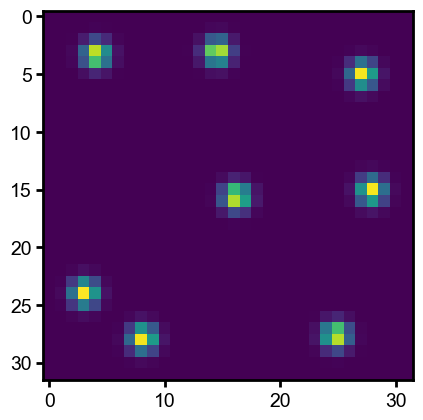

In [29]:
mnist_heuristic_init_mi_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/mi_estimates/mnist_diagonal_cov_sigma_08_heuristic_init_means_and_covs_8_lenslets_4096_patches_5e-3_mean_0_weights_lr_clean_images_seed_42.npy'
mi_values = np.load(mnist_heuristic_init_mi_path, allow_pickle=True)
best_mnist_heuristic_mi, best_mnist_heuristic_lower, best_mnist_heuristic_upper = mi_values
best_mnist_heuristic_mi_lenslet_count = 8

mnist_heuristic_init_tc_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/tc_values/mnist_diagonal_cov_sigma_08_heuristic_init_means_and_covs_8_lenslets_4096_patches_5e-3_mean_0_weights_lr_clean_images_seed_42.npy'
tc_values = np.load(mnist_heuristic_init_tc_path, allow_pickle=True).item()
best_mnist_heuristic_tc = tc_values['patch_noisy'][0]
print(best_mnist_heuristic_tc)

mnist_heuristic_init_model_path = '/home/lakabuli/workspace/LenslessInfoDesign/design_IDEAL/data/models/mnist_diagonal_cov_sigma_08_heuristic_init_means_and_covs_8_lenslets_4096_patches_5e-3_mean_0_weights_lr_clean_images_seed_42_optimized_imaging_system.eqx'

psf_layer = RMLPSFLayerDiagCovs(object_size, 8, psf_size, key=key)

imaging_system = LenslessImagingSystem(psf_layer)

loaded_imaging_system = eqx.tree_deserialise_leaves(mnist_heuristic_init_model_path, imaging_system)

print(loaded_imaging_system.psf_layer.weights)
mnist_heuristic_psf_image = loaded_imaging_system.psf_layer.compute_psf()
plt.imshow(mnist_heuristic_psf_image)

In [30]:
np.save(ideal_psfs_save_as_npy_dir + 'ideal_heuristic_mnist_psf.npy', mnist_heuristic_psf_image)

## Plots for IDEAL Figures: Fig. 3 and Fig. S8

In [31]:
random_init_optimum_symbol = 'D'
random_init_optimum_symbol_size = 90
heuristic_init_optimum_symbol = '*'
heuristic_init_optimum_symbol_size = 190
best_heuristic_init_symbol = 'o' 
best_heuristic_init_symbol_size = 70
random_init_symbol = 'x'
random_init_symbol_size = 100
errorbar_capsize = 5
mnist_color = get_color_cycle()[2] 
fashion_color = get_color_cycle()[1]
cifar_color = get_color_cycle()[0]
bead_color = get_color_cycle()[6]

colors_to_use = [cifar_color, fashion_color, mnist_color, bead_color]

heuristic_marker_size = 5

In [32]:
axis_label_fontsize = 21
title_fontsize = 23
tick_fontsize = 19
legend_fontsize = 16

#### Figure 3 Plot

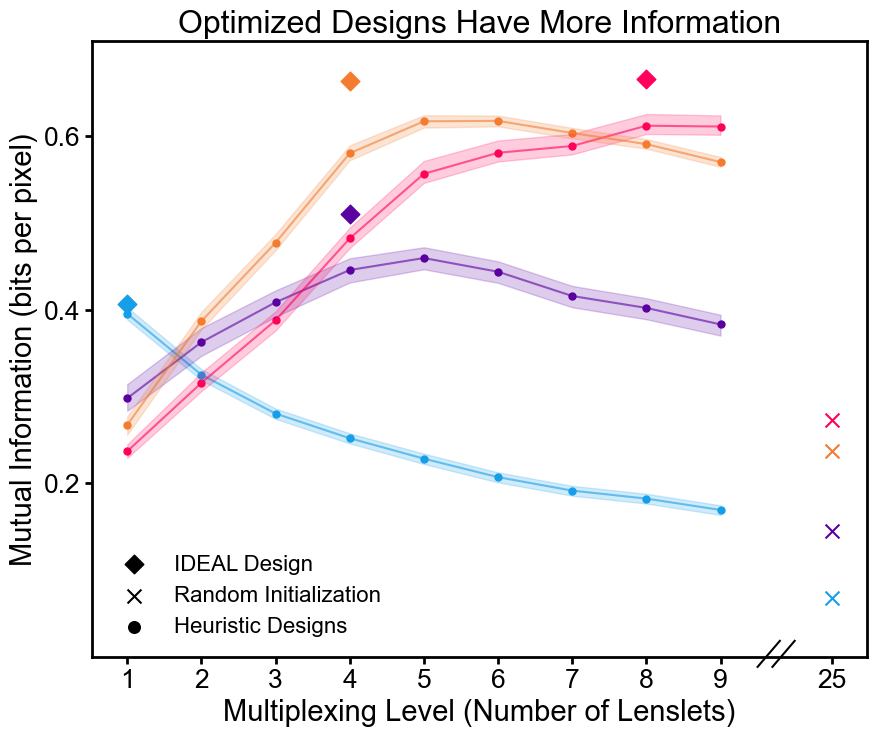

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
# best MNIST design from random init and errorbars 
plt.scatter([10.5], [mnist_random_init_psf_mi], color=mnist_color, marker=random_init_symbol, s=random_init_symbol_size, zorder=0)
plt.scatter(best_mnist_mi_lenslet_count, best_mnist_mi, color=mnist_color, marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, zorder=2)
#plt.fill_between([best_mnist_mi_lenslet_count-0.1, best_mnist_mi_lenslet_count, best_mnist_mi_lenslet_count + 0.1], [best_mnist_lower, best_mnist_lower, best_mnist_lower], [best_mnist_upper, best_mnist_upper, best_mnist_upper], color=mnist_color, alpha=0.2, zorder=1)
#plt.errorbar(best_mnist_mi_lenslet_count, best_mnist_mi, yerr=[[best_mnist_mi - best_mnist_lower], [best_mnist_upper - best_mnist_mi]], fmt='none', color=get_color_cycle()[2], capsize=errorbar_capsize, zorder=2)
# best MNIST design from heuristic init and errorbars
#plt.scatter(best_mnist_heuristic_mi_lenslet_count, best_mnist_heuristic_mi, color=mnist_color, marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_mnist_heuristic_mi_lenslet_count, best_mnist_heuristic_mi, yerr=[[best_mnist_heuristic_mi - best_mnist_heuristic_lower], [best_mnist_heuristic_upper - best_mnist_heuristic_mi]], fmt='none', color=mnist_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_mnist_heuristic_mi_lenslet_count - 0.1, best_mnist_heuristic_mi_lenslet_count, best_mnist_heuristic_mi_lenslet_count + 0.1], [best_mnist_heuristic_lower, best_mnist_heuristic_lower, best_mnist_heuristic_lower], [best_mnist_heuristic_upper, best_mnist_heuristic_upper, best_mnist_heuristic_upper], color=mnist_color, alpha=0.2, zorder=1)

# best CIFAR10 design from random init and errorbars
plt.scatter([10.5], [cifar_random_init_psf_mi], color=cifar_color, marker=random_init_symbol, s=random_init_symbol_size, zorder=0)
plt.scatter(best_cifar_mi_lenslet_count, best_cifar_mi, color=cifar_color, marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_cifar_mi_lenslet_count, best_cifar_mi, yerr=[[best_cifar_mi - best_cifar_lower], [best_cifar_upper - best_cifar_mi]], fmt='none', color=cifar_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_cifar_mi_lenslet_count - 0.1, best_cifar_mi_lenslet_count, best_cifar_mi_lenslet_count + 0.1], [best_cifar_lower, best_cifar_lower, best_cifar_lower], [best_cifar_upper, best_cifar_upper, best_cifar_upper], color=cifar_color, alpha=0.2, zorder=2)
# best CIFAR10 design from heuristic init and errorbars
#plt.scatter(best_cifar_heuristic_mi_lenslet_count, best_cifar_heuristic_mi, color=cifar_color, marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_cifar_heuristic_mi_lenslet_count, best_cifar_heuristic_mi, yerr=[[best_cifar_heuristic_mi - best_cifar_heuristic_lower], [best_cifar_heuristic_upper - best_cifar_heuristic_mi]], fmt='none', color=cifar_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_cifar_heuristic_mi_lenslet_count - 0.1, best_cifar_heuristic_mi_lenslet_count, best_cifar_heuristic_mi_lenslet_count + 0.1], [best_cifar_heuristic_lower, best_cifar_heuristic_lower, best_cifar_heuristic_lower], [best_cifar_heuristic_upper, best_cifar_heuristic_upper, best_cifar_heuristic_upper], color=cifar_color, alpha=0.2, zorder=2)

# best Fashion design from random init and errorbars
plt.scatter([10.5], [fashion_random_init_psf_mi], color=fashion_color, marker=random_init_symbol, s=random_init_symbol_size, zorder=0)
plt.scatter(best_fashion_mi_lenslet_count, best_fashion_mi, color=fashion_color, marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_fashion_mi_lenslet_count, best_fashion_mi, yerr=[[best_fashion_mi - best_fashion_lower], [best_fashion_upper - best_fashion_mi]], fmt='none', color=fashion_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_fashion_mi_lenslet_count - 0.1, best_fashion_mi_lenslet_count, best_fashion_mi_lenslet_count + 0.1], [best_fashion_lower, best_fashion_lower, best_fashion_lower], [best_fashion_upper, best_fashion_upper, best_fashion_upper], color=fashion_color, alpha=0.2, zorder=2)
# best Fashion design from heuristic init and errorbars
#plt.scatter(best_fashion_heuristic_mi_lenslet_count, best_fashion_heuristic_mi, color=fashion_color, marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_fashion_heuristic_mi_lenslet_count, best_fashion_heuristic_mi, yerr=[[best_fashion_heuristic_mi - best_fashion_heuristic_lower], [best_fashion_heuristic_upper - best_fashion_heuristic_mi]], fmt='none', color=fashion_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_fashion_heuristic_mi_lenslet_count - 0.1, best_fashion_heuristic_mi_lenslet_count, best_fashion_heuristic_mi_lenslet_count + 0.1], [best_fashion_heuristic_lower, best_fashion_heuristic_lower, best_fashion_heuristic_lower], [best_fashion_heuristic_upper, best_fashion_heuristic_upper, best_fashion_heuristic_upper], color=fashion_color, alpha=0.2, zorder=2)

# best Bead design for sparsity 0.02 from random init and errorbars 
plt.scatter([10.5], [bead_random_init_psf_mi], color=bead_color, marker=random_init_symbol, s=random_init_symbol_size, zorder=0)
plt.scatter(best_bead_mi_lenslet_count, best_bead_mi, color=bead_color, marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, zorder=2)
#plt.fill_between([best_bead_mi_lenslet_count - 0.1, best_bead_mi_lenslet_count, best_bead_mi_lenslet_count + 0.1], [best_bead_lower, best_bead_lower, best_bead_lower], [best_bead_upper, best_bead_upper, best_bead_upper], color=bead_color, alpha=0.2, zorder=2)
# best Bead design from heuristic init and errorbars 
#plt.scatter(best_bead_heuristic_lenslet_count, best_bead_heuristic_mi, color=bead_color, marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, zorder=2)
#plt.fill_between([best_bead_heuristic_lenslet_count - 0.1, best_bead_heuristic_lenslet_count, best_bead_heuristic_lenslet_count + 0.1], [best_bead_heuristic_lower, best_bead_heuristic_lower, best_bead_heuristic_lower], [best_bead_heuristic_upper, best_bead_heuristic_upper, best_bead_heuristic_upper], color=bead_color, alpha=0.2, zorder=2)

heuristic_lenslet_indices = [0, 3, 7, 4] # cifar, fashion, mnist, bead
# heuristic MI designs 
for idx, dataset in enumerate(dataset_names): 
    plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9], mi_estimates_across_datasets[idx], color=colors_to_use[idx], zorder=1, alpha=0.6)
    plt.scatter([1, 2, 3, 4, 5, 6, 7, 8, 9], mi_estimates_across_datasets[idx], color=colors_to_use[idx], marker='o', s=25, zorder=0)
    plt.fill_between([1, 2, 3, 4, 5, 6, 7, 8, 9], mi_lower_bounds_across_datasets[idx], mi_upper_bounds_across_datasets[idx], color=colors_to_use[idx], alpha=0.2, zorder=1)
    # best heuristic MI point - not necessary
    #plt.scatter(heuristic_lenslet_indices[idx] + 1, mi_estimates_across_datasets[idx][heuristic_lenslet_indices[idx]], color=get_color_cycle()[idx], marker=best_heuristic_init_symbol, s=best_heuristic_init_symbol_size)
    #plt.scatter(np.argmax(mi_estimates_across_datasets[idx]) + 1, np.max(mi_estimates_across_datasets[idx]), color=get_color_cycle()[idx], marker=best_heuristic_init_symbol, s=best_heuristic_init_symbol_size)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10.5])
ax.set_xticklabels([str(i) for i in range(1, 10)] + ['25'], size=tick_fontsize)

break_pos = (9.5, 10)  # Where the break is
ylim = ax.get_ylim()  # Get current y limits

ax.plot([break_pos[0], break_pos[0] + 0.3], [ylim[0] - 0.05, ylim[0] - 0.02], 'k', clip_on=False)  # Left break
ax.plot([break_pos[1] - 0.3, break_pos[1]], [ylim[0] - 0.05, ylim[0] - 0.02], 'k', clip_on=False)  # Right break


plt.xlabel("Multiplexing Level (Number of Lenslets)", size=axis_label_fontsize) 
plt.yticks([0.2, 0.4, 0.6], size=tick_fontsize)
plt.ylim([0, 0.71])
plt.ylabel("Mutual Information (bits per pixel)", size=axis_label_fontsize)
plt.title("Optimized Designs Have More Information", size=title_fontsize)

# Define dummy handles for legend symbols
random_init_handle = plt.scatter([], [], color='black', marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, label='IDEAL Design')
heuristic_init_handle = plt.scatter([], [], color='black', marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, label='Design With Heuristic Initialization')
heuristic_handle = plt.scatter([], [], color='black', marker='o', s=best_heuristic_init_symbol_size, label='Heuristic Designs')
ideal_design_handle = plt.scatter([], [], color='black', marker=random_init_symbol, s=random_init_symbol_size, label='Random Initialization')

# Build custom legend
handles, labels = plt.gca().get_legend_handles_labels()
custom_handles = [random_init_handle, ideal_design_handle, heuristic_handle]
custom_labels = [h.get_label() for h in custom_handles]

# Add MI curves (from the for-loop in your code) to the legend
mi_handles = [h for h, l in zip(handles, labels) if l in dataset_names_nice]
custom_handles += mi_handles
custom_labels += dataset_names_nice

plt.legend(custom_handles, custom_labels, fontsize=legend_fontsize, frameon=False, loc='lower left')
plt.savefig(figure_folder + 'IDEAL_MI.pdf', bbox_inches='tight', transparent=True)

#### Figure S8 Plot

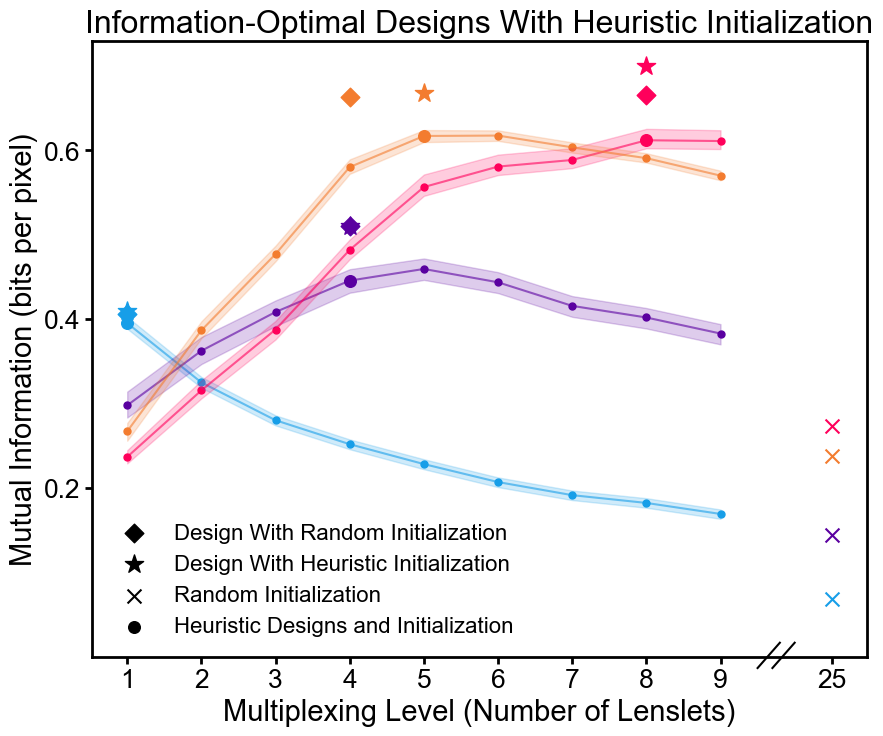

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
# best MNIST design from random init and errorbars 
plt.scatter([10.5], [mnist_random_init_psf_mi], color=mnist_color, marker=random_init_symbol, s=random_init_symbol_size, zorder=0)
plt.scatter(best_mnist_mi_lenslet_count, best_mnist_mi, color=mnist_color, marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, zorder=2)
#plt.fill_between([best_mnist_mi_lenslet_count-0.1, best_mnist_mi_lenslet_count, best_mnist_mi_lenslet_count + 0.1], [best_mnist_lower, best_mnist_lower, best_mnist_lower], [best_mnist_upper, best_mnist_upper, best_mnist_upper], color=mnist_color, alpha=0.2, zorder=1)
#plt.errorbar(best_mnist_mi_lenslet_count, best_mnist_mi, yerr=[[best_mnist_mi - best_mnist_lower], [best_mnist_upper - best_mnist_mi]], fmt='none', color=get_color_cycle()[2], capsize=errorbar_capsize, zorder=2)
# best MNIST design from heuristic init and errorbars
plt.scatter(best_mnist_heuristic_mi_lenslet_count, best_mnist_heuristic_mi, color=mnist_color, marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_mnist_heuristic_mi_lenslet_count, best_mnist_heuristic_mi, yerr=[[best_mnist_heuristic_mi - best_mnist_heuristic_lower], [best_mnist_heuristic_upper - best_mnist_heuristic_mi]], fmt='none', color=mnist_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_mnist_heuristic_mi_lenslet_count - 0.1, best_mnist_heuristic_mi_lenslet_count, best_mnist_heuristic_mi_lenslet_count + 0.1], [best_mnist_heuristic_lower, best_mnist_heuristic_lower, best_mnist_heuristic_lower], [best_mnist_heuristic_upper, best_mnist_heuristic_upper, best_mnist_heuristic_upper], color=mnist_color, alpha=0.2, zorder=1)

# best CIFAR10 design from random init and errorbars
plt.scatter([10.5], [cifar_random_init_psf_mi], color=cifar_color, marker=random_init_symbol, s=random_init_symbol_size, zorder=0)
plt.scatter(best_cifar_mi_lenslet_count, best_cifar_mi, color=cifar_color, marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_cifar_mi_lenslet_count, best_cifar_mi, yerr=[[best_cifar_mi - best_cifar_lower], [best_cifar_upper - best_cifar_mi]], fmt='none', color=cifar_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_cifar_mi_lenslet_count - 0.1, best_cifar_mi_lenslet_count, best_cifar_mi_lenslet_count + 0.1], [best_cifar_lower, best_cifar_lower, best_cifar_lower], [best_cifar_upper, best_cifar_upper, best_cifar_upper], color=cifar_color, alpha=0.2, zorder=2)
# best CIFAR10 design from heuristic init and errorbars
plt.scatter(best_cifar_heuristic_mi_lenslet_count, best_cifar_heuristic_mi, color=cifar_color, marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_cifar_heuristic_mi_lenslet_count, best_cifar_heuristic_mi, yerr=[[best_cifar_heuristic_mi - best_cifar_heuristic_lower], [best_cifar_heuristic_upper - best_cifar_heuristic_mi]], fmt='none', color=cifar_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_cifar_heuristic_mi_lenslet_count - 0.1, best_cifar_heuristic_mi_lenslet_count, best_cifar_heuristic_mi_lenslet_count + 0.1], [best_cifar_heuristic_lower, best_cifar_heuristic_lower, best_cifar_heuristic_lower], [best_cifar_heuristic_upper, best_cifar_heuristic_upper, best_cifar_heuristic_upper], color=cifar_color, alpha=0.2, zorder=2)

# best Fashion design from random init and errorbars
plt.scatter([10.5], [fashion_random_init_psf_mi], color=fashion_color, marker=random_init_symbol, s=random_init_symbol_size, zorder=0)
plt.scatter(best_fashion_mi_lenslet_count, best_fashion_mi, color=fashion_color, marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_fashion_mi_lenslet_count, best_fashion_mi, yerr=[[best_fashion_mi - best_fashion_lower], [best_fashion_upper - best_fashion_mi]], fmt='none', color=fashion_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_fashion_mi_lenslet_count - 0.1, best_fashion_mi_lenslet_count, best_fashion_mi_lenslet_count + 0.1], [best_fashion_lower, best_fashion_lower, best_fashion_lower], [best_fashion_upper, best_fashion_upper, best_fashion_upper], color=fashion_color, alpha=0.2, zorder=2)
# best Fashion design from heuristic init and errorbars
plt.scatter(best_fashion_heuristic_mi_lenslet_count, best_fashion_heuristic_mi, color=fashion_color, marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, zorder=2)
#plt.errorbar(best_fashion_heuristic_mi_lenslet_count, best_fashion_heuristic_mi, yerr=[[best_fashion_heuristic_mi - best_fashion_heuristic_lower], [best_fashion_heuristic_upper - best_fashion_heuristic_mi]], fmt='none', color=fashion_color, capsize=errorbar_capsize, zorder=2)
#plt.fill_between([best_fashion_heuristic_mi_lenslet_count - 0.1, best_fashion_heuristic_mi_lenslet_count, best_fashion_heuristic_mi_lenslet_count + 0.1], [best_fashion_heuristic_lower, best_fashion_heuristic_lower, best_fashion_heuristic_lower], [best_fashion_heuristic_upper, best_fashion_heuristic_upper, best_fashion_heuristic_upper], color=fashion_color, alpha=0.2, zorder=2)

# best Bead design for sparsity 0.02 from random init and errorbars 
plt.scatter([10.5], [bead_random_init_psf_mi], color=bead_color, marker=random_init_symbol, s=random_init_symbol_size, zorder=0)
plt.scatter(best_bead_mi_lenslet_count, best_bead_mi, color=bead_color, marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, zorder=2)
#plt.fill_between([best_bead_mi_lenslet_count - 0.1, best_bead_mi_lenslet_count, best_bead_mi_lenslet_count + 0.1], [best_bead_lower, best_bead_lower, best_bead_lower], [best_bead_upper, best_bead_upper, best_bead_upper], color=bead_color, alpha=0.2, zorder=2)
# best Bead design from heuristic init and errorbars 
plt.scatter(best_bead_heuristic_lenslet_count, best_bead_heuristic_mi, color=bead_color, marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, zorder=2)
#plt.fill_between([best_bead_heuristic_lenslet_count - 0.1, best_bead_heuristic_lenslet_count, best_bead_heuristic_lenslet_count + 0.1], [best_bead_heuristic_lower, best_bead_heuristic_lower, best_bead_heuristic_lower], [best_bead_heuristic_upper, best_bead_heuristic_upper, best_bead_heuristic_upper], color=bead_color, alpha=0.2, zorder=2)

heuristic_lenslet_indices = [0, 3, 7, 4] # cifar, fashion, mnist, bead
# heuristic MI designs 
for idx, dataset in enumerate(dataset_names): 
    plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9], mi_estimates_across_datasets[idx], color=colors_to_use[idx], zorder=1, alpha=0.6)
    plt.scatter([1, 2, 3, 4, 5, 6, 7, 8, 9], mi_estimates_across_datasets[idx], color=colors_to_use[idx], marker='o', s=25, zorder=0)
    plt.fill_between([1, 2, 3, 4, 5, 6, 7, 8, 9], mi_lower_bounds_across_datasets[idx], mi_upper_bounds_across_datasets[idx], color=colors_to_use[idx], alpha=0.2, zorder=1)
    # best heuristic MI point - not necessary
    plt.scatter(heuristic_lenslet_indices[idx] + 1, mi_estimates_across_datasets[idx][heuristic_lenslet_indices[idx]], color=colors_to_use[idx], marker=best_heuristic_init_symbol, s=best_heuristic_init_symbol_size)
    #plt.scatter(np.argmax(mi_estimates_across_datasets[idx]) + 1, np.max(mi_estimates_across_datasets[idx]), color=get_color_cycle()[idx], marker=best_heuristic_init_symbol, s=best_heuristic_init_symbol_size)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10.5])
ax.set_xticklabels([str(i) for i in range(1, 10)] + ['25'], size=tick_fontsize)

break_pos = (9.5, 10)  # Where the break is
ylim = ax.get_ylim()  # Get current y limits

ax.plot([break_pos[0], break_pos[0] + 0.3], [ylim[0] - 0.05, ylim[0] - 0.02], 'k', clip_on=False)  # Left break
ax.plot([break_pos[1] - 0.3, break_pos[1]], [ylim[0] - 0.05, ylim[0] - 0.02], 'k', clip_on=False)  # Right break


plt.xlabel("Multiplexing Level (Number of Lenslets)", size=axis_label_fontsize) 
plt.yticks([0.2, 0.4, 0.6], size=tick_fontsize)
plt.ylim([0, 0.73])
plt.ylabel("Mutual Information (bits per pixel)", size=axis_label_fontsize)
plt.title("Information-Optimal Designs With Heuristic Initialization", size=title_fontsize)

# Define dummy handles for legend symbols
random_init_handle = plt.scatter([], [], color='black', marker=random_init_optimum_symbol, s=random_init_optimum_symbol_size, label='Design With Random Initialization')
heuristic_init_handle = plt.scatter([], [], color='black', marker=heuristic_init_optimum_symbol, s=heuristic_init_optimum_symbol_size, label='Design With Heuristic Initialization')
heuristic_handle = plt.scatter([], [], color='black', marker='o', s=best_heuristic_init_symbol_size, label='Heuristic Designs and Initialization')
ideal_design_handle = plt.scatter([], [], color='black', marker=random_init_symbol, s=random_init_symbol_size, label='Random Initialization')

# Build custom legend
handles, labels = plt.gca().get_legend_handles_labels()
#custom_handles = [random_init_handle, heuristic_init_handle, ideal_design_handle, heuristic_handle]#, heuristic_mi_curve_handle]
custom_handles = [random_init_handle, heuristic_init_handle, ideal_design_handle, heuristic_handle]
custom_labels = [h.get_label() for h in custom_handles]

# Add MI curves (from the for-loop in your code) to the legend
mi_handles = [h for h, l in zip(handles, labels) if l in dataset_names_nice]
custom_handles += mi_handles
custom_labels += dataset_names_nice

plt.legend(custom_handles, custom_labels, fontsize=legend_fontsize, frameon=False, loc='lower left')
plt.savefig(figure_folder + 'IDEAL_supplement_MI.pdf', bbox_inches='tight', transparent=True)

## Plot all of the lenslets: Fig. S7a, b

In [35]:
import matplotlib.colors as mcolors 

lime = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ['black', 'lime'])

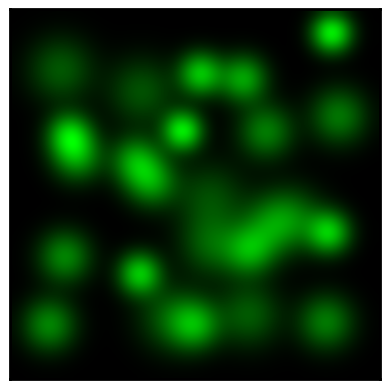

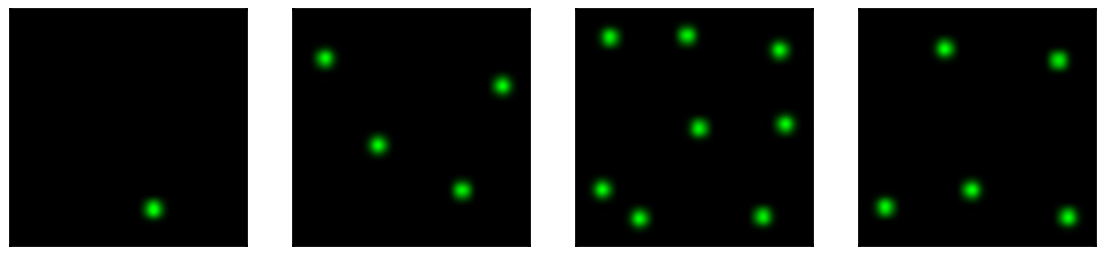

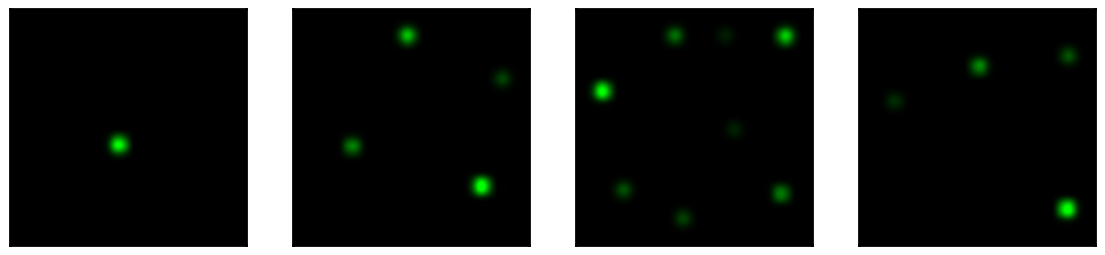

In [36]:
plt.figure()
plt.imshow(random_init_psf, cmap=lime, interpolation='spline36')
# clear the axes 
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig(figure_folder + 'random_init_psf.pdf', transparent=True, bbox_inches='tight', dpi=300)

plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1)
plt.imshow(cifar_heuristic_psf_image, cmap=lime, interpolation='spline36')
# clear the axes 
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(1, 4, 2)
plt.imshow(fashion_heuristic_psf_image, cmap=lime, interpolation='spline36')
# clear the axes 
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(1, 4, 3)
plt.imshow(mnist_heuristic_psf_image, cmap=lime, interpolation='spline36')
# clear the axes 
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(1, 4, 4)
plt.imshow(bead_heuristic_psf_image, cmap=lime, interpolation='spline36')
# clear the axes
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.savefig(figure_folder + 'heuristic_init_ideal_psfs.pdf', bbox_inches='tight', transparent=True)

plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1)
plt.imshow(cifar_psf_image, cmap=lime, interpolation='spline36')
# clear the axes 
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(1, 4, 2)
plt.imshow(fashion_psf_image, cmap=lime, interpolation='spline36')
# clear the axes 
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(1, 4, 3)
plt.imshow(mnist_psf_image, cmap=lime, interpolation='spline36')
# clear the axes 
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(1, 4, 4)
plt.imshow(bead_psf_image, cmap=lime, interpolation='spline36')
# clear the axes
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig(figure_folder + 'random_init_ideal_psfs.pdf', bbox_inches='tight', transparent=True)

## Make measurements with the existing lenslets

In [37]:
photon_count = 100
seed_value = 18

In [ ]:
dataset_names = ['cifar10', 'fashion_mnist', 'mnist', 'bead']
random_psfs_to_sweep = [cifar_psf_image, fashion_psf_image, mnist_psf_image, bead_psf_image] 
heuristic_psfs_to_sweep = [cifar_heuristic_psf_image, fashion_heuristic_psf_image, mnist_heuristic_psf_image, bead_heuristic_psf_image]


In [39]:
heuristic_tc_values = [best_cifar_heuristic_tc, best_fashion_heuristic_tc, best_mnist_heuristic_tc, best_bead_heuristic_tc]
random_tc_values = [best_cifar_tc, best_fashion_tc, best_mnist_tc, best_bead_tc]
print(heuristic_tc_values, random_tc_values)

[np.float32(0.85230196), np.float32(0.8060982), np.float32(0.7595499), np.float32(0.75834507)] [np.float32(0.8527488), np.float32(0.880128), np.float32(0.8786029), np.float32(0.8378397)]


### Make measurements for heuristic init PSFs: Fig. S8d

In [40]:
init_kind = 'heuristic'

Loading CIFAR10 dataset


2025-12-23 18:25:02.583745: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1766543102.584036 3837215 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8556 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:67:00.0, compute capability: 6.1
2025-12-23 18:25:02.587222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.


(60000, 32, 32)


Convolving images: 100%|██████████| 1000/1000 [00:00<00:00, 2377.46image/s]


Loading Fashion MNIST dataset
(70000, 32, 32)


Convolving images: 100%|██████████| 1000/1000 [00:00<00:00, 2464.91image/s]


Loading MNIST dataset
(70000, 32, 32)


Convolving images: 100%|██████████| 1000/1000 [00:00<00:00, 2054.39image/s]


Loading bead dataset
0.02


Convolving images: 100%|██████████| 1000/1000 [00:00<00:00, 3381.25image/s]


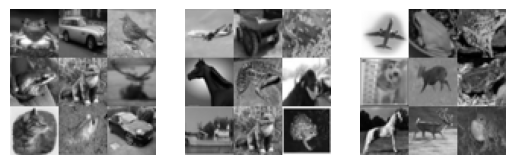

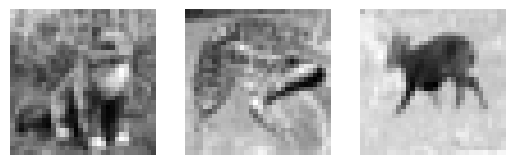

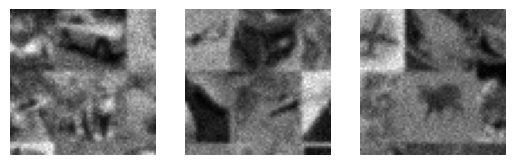

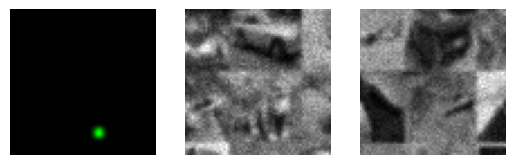

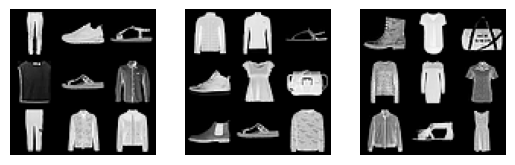

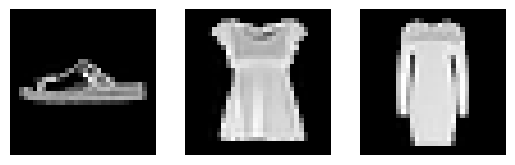

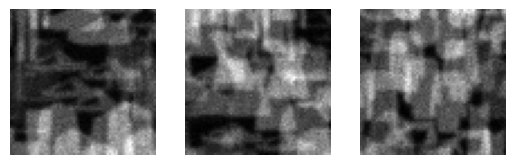

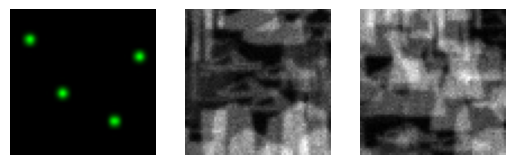

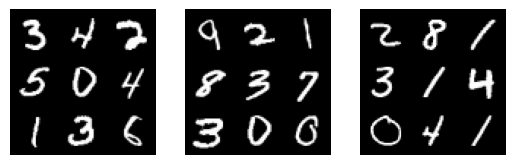

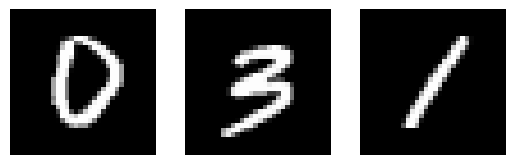

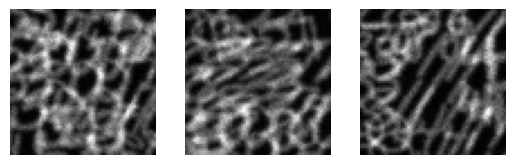

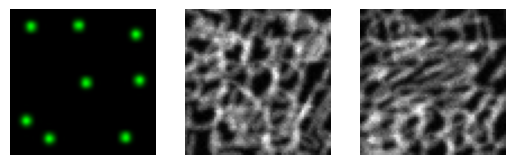

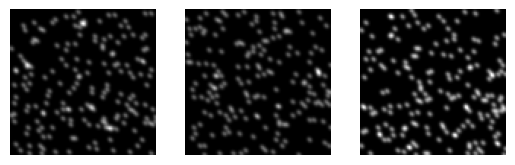

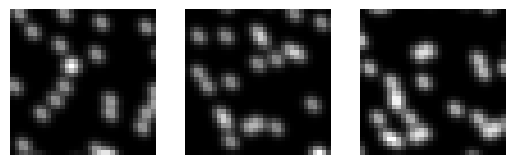

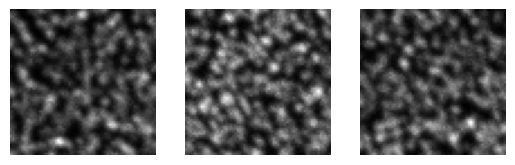

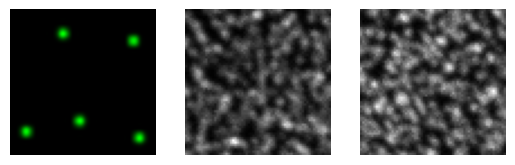

In [41]:
for psf_idx, psf_image in enumerate(heuristic_psfs_to_sweep):
    dataset_name = dataset_names[psf_idx]
    if dataset_name == 'mnist':
        print("Loading MNIST dataset")
        (x_train, y_train), (x_test, y_test) = mnist.load_data() 
        data = np.concatenate([x_train, x_test], axis=0)
        labels = np.concatenate([y_train, y_test], axis=0)
        data = np.pad(data, ((0, 0), (2, 2), (2, 2)), 'constant')
    elif dataset_name == 'fashion_mnist':
        print("Loading Fashion MNIST dataset")
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        data = np.concatenate([x_train, x_test], axis=0)
        labels = np.concatenate([y_train, y_test], axis=0)
        data = np.pad(data, ((0, 0), (2, 2), (2, 2)), 'constant')
    elif dataset_name == 'cifar10':
        print("Loading CIFAR10 dataset")
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        data = np.concatenate([x_train, x_test], axis=0)
        labels = np.concatenate([y_train, y_test], axis=0)
    elif dataset_name == 'bead':
        print("Loading bead dataset")
        print(sparsity_level)
        dataset = np.zeros((1000, 96, 96))
        for i in range(dataset.shape[0]):
            vol, num_points = make_bead_volume(sparsity_level, bead_width_scale=1, numx=96, numy=96) 
            dataset[i] = vol 
        dataset = dataset.astype(np.float32) 
        dataset_photons = dataset / np.mean(dataset) 
        random_data = dataset_photons * mean_photon_count 
    else:
        raise ValueError('Invalid dataset name')
    if len(data.shape) == 4:
        data = tf.image.rgb_to_grayscale(data).numpy()
        data = data.squeeze()
    data = data.astype(np.float32) 
    if dataset_name != 'bead':
        # convert to photons 
        data = data / np.mean(data) 
        data = data * photon_count 
        print(data.shape)
        # slice just the first few images 
        data = data[:1000]
        # make tiled data 
        random_data, random_labels = generate_random_tiled_data(data, labels, seed_value) 
    # convolve the data 
    psf_data = convolved_dataset(psf_image, random_data) 
    # add small bias to data 
    psf_data += bias 
    # add noise to the full measurements 
    psf_data_noisy = add_noise(psf_data, seed=seed_value)

    # make the input object set 
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(random_data[0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(random_data[1], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(random_data[2], cmap='gray')
    plt.axis('off')
    plt.savefig(figure_folder + '{}_{}_input_objects.pdf'.format(dataset_name, init_kind), bbox_inches='tight', transparent=True)
    # make the cropped center 32 x 32 object set 
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(random_data[0][32:64, 32:64], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(random_data[1][32:64, 32:64], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(random_data[2][32:64, 32:64], cmap='gray')
    plt.axis('off')
    plt.savefig(figure_folder + '{}_{}_cropped_objects.pdf'.format(dataset_name, init_kind), bbox_inches='tight', transparent=True)
    # make the noisy measurement set 
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(psf_data_noisy[0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(psf_data_noisy[1], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(psf_data_noisy[2], cmap='gray')
    plt.axis('off')
    #plt.savefig(figure_folder + '{}_{}_noisy_measurements.pdf'.format(dataset_name, init_kind), bbox_inches='tight', transparent=True)
    # make the noisy measurement set 
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(psf_image, cmap=lime, interpolation='spline36')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(psf_data_noisy[0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(psf_data_noisy[1], cmap='gray')
    plt.axis('off')
    plt.savefig(figure_folder + '{}_{}_psf_and_noisy_measurements.pdf'.format(dataset_name, init_kind), bbox_inches='tight', transparent=True)

### Make measurements for random init PSFs: Fig. 3c, Fig. S8b

In [42]:
init_kind = 'random' # 'random' or 'heuristic'

Loading CIFAR10 dataset


2025-12-23 18:25:21.665492: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.


(60000, 32, 32)


Convolving images: 100%|██████████| 1000/1000 [00:00<00:00, 1865.42image/s]


Loading Fashion MNIST dataset
(70000, 32, 32)


Convolving images: 100%|██████████| 1000/1000 [00:00<00:00, 2517.23image/s]


Loading MNIST dataset
(70000, 32, 32)


Convolving images: 100%|██████████| 1000/1000 [00:00<00:00, 2166.22image/s]


Loading bead dataset
0.02


Convolving images: 100%|██████████| 1000/1000 [00:00<00:00, 3375.39image/s]


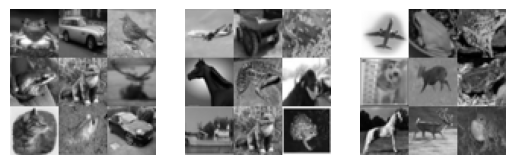

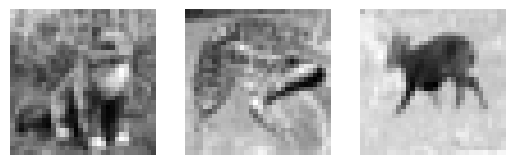

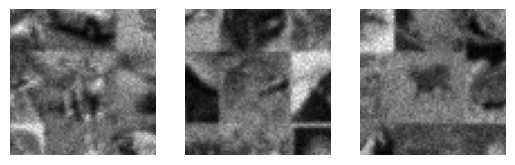

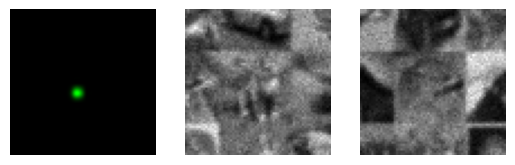

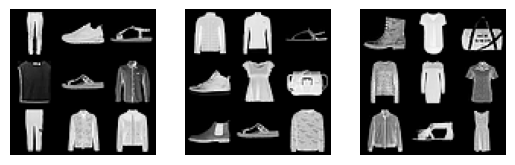

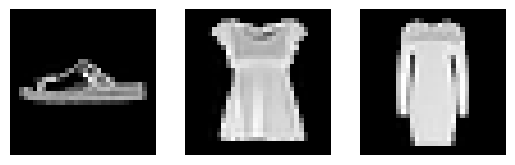

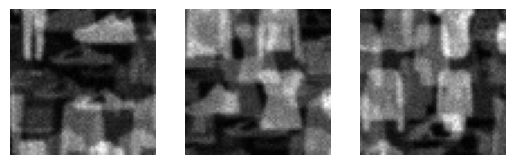

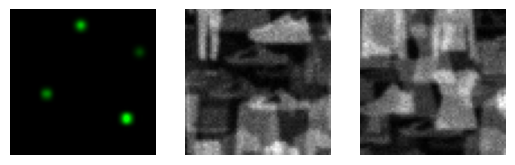

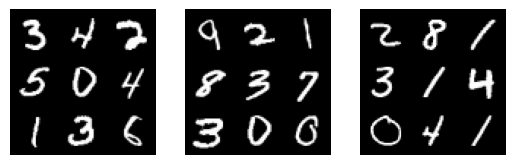

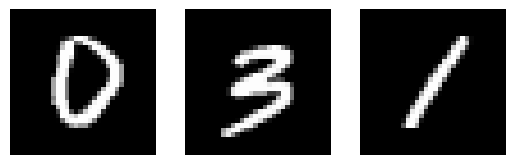

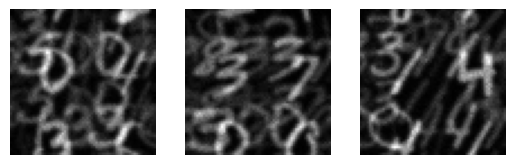

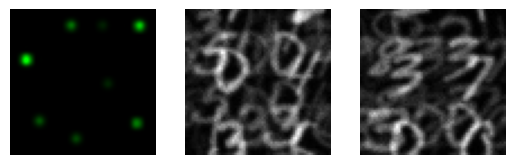

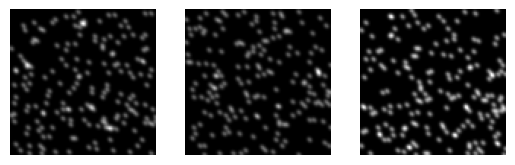

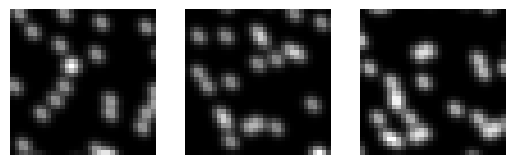

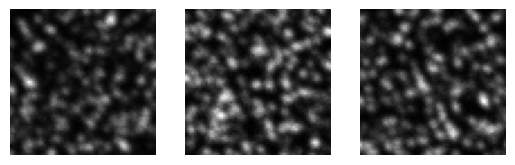

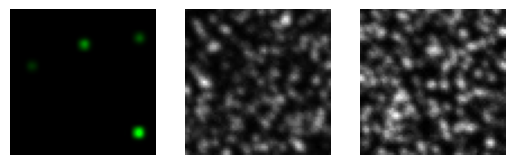

In [43]:
for psf_idx, psf_image in enumerate(random_psfs_to_sweep):
    dataset_name = dataset_names[psf_idx]
    if dataset_name == 'mnist':
        print("Loading MNIST dataset")
        (x_train, y_train), (x_test, y_test) = mnist.load_data() 
        data = np.concatenate([x_train, x_test], axis=0)
        labels = np.concatenate([y_train, y_test], axis=0)
        data = np.pad(data, ((0, 0), (2, 2), (2, 2)), 'constant')
    elif dataset_name == 'fashion_mnist':
        print("Loading Fashion MNIST dataset")
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        data = np.concatenate([x_train, x_test], axis=0)
        labels = np.concatenate([y_train, y_test], axis=0)
        data = np.pad(data, ((0, 0), (2, 2), (2, 2)), 'constant')
    elif dataset_name == 'cifar10':
        print("Loading CIFAR10 dataset")
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        data = np.concatenate([x_train, x_test], axis=0)
        labels = np.concatenate([y_train, y_test], axis=0)

    elif dataset_name == 'bead':
        print("Loading bead dataset")
        print(sparsity_level)
        dataset = np.zeros((1000, 96, 96)) 
        for i in range(dataset.shape[0]):
            vol, num_points = make_bead_volume(sparsity_level, bead_width_scale=1, numx=96, numy=96) 
            dataset[i] = vol 
        dataset = dataset.astype(np.float32) 
        dataset_photons = dataset / np.mean(dataset) 
        random_data = dataset_photons * mean_photon_count 
    else:
        raise ValueError('Invalid dataset name')
    if len(data.shape) == 4:
        data = tf.image.rgb_to_grayscale(data).numpy()
        data = data.squeeze()
    data = data.astype(np.float32) 
    if dataset_name != 'bead':
        # convert to photons 
        data = data / np.mean(data) 
        data = data * photon_count 
        print(data.shape)
        # slice just the first few images 
        data = data[:1000]
        # make tiled data 
        random_data, random_labels = generate_random_tiled_data(data, labels, seed_value) 
    # convolve the data 
    psf_data = convolved_dataset(psf_image, random_data) 
    # add small bias to data 
    psf_data += bias 
    # add noise to the full measurements 
    psf_data_noisy = add_noise(psf_data, seed=seed_value)

    # make the input object set 
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(random_data[0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(random_data[1], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(random_data[2], cmap='gray')
    plt.axis('off')
    plt.savefig(figure_folder + '{}_{}_input_objects.pdf'.format(dataset_name, init_kind), bbox_inches='tight', transparent=True)
    # make the cropped center 32 x 32 object set 
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(random_data[0][32:64, 32:64], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(random_data[1][32:64, 32:64], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(random_data[2][32:64, 32:64], cmap='gray')
    plt.axis('off')
    plt.savefig(figure_folder + '{}_{}_cropped_objects.pdf'.format(dataset_name, init_kind), bbox_inches='tight', transparent=True)
    # make the noisy measurement set 
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(psf_data_noisy[0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(psf_data_noisy[1], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(psf_data_noisy[2], cmap='gray')
    plt.axis('off')
    #plt.savefig(figure_folder + '{}_{}_noisy_measurements.pdf'.format(dataset_name, init_kind), bbox_inches='tight', transparent=True)
    # make the noisy measurement set 
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(psf_image, cmap=lime, interpolation='spline36')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(psf_data_noisy[0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(psf_data_noisy[1], cmap='gray')
    plt.axis('off')
    plt.savefig(figure_folder + '{}_{}_psf_and_noisy_measurements.pdf'.format(dataset_name, init_kind), bbox_inches='tight', transparent=True)